In [6]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import os
import matplotlib.pyplot as plt

class PhysicsInformedNN:
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        self.lb = lb
        self.ub = ub

        self.x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
        self.t0 = torch.tensor(np.zeros_like(x0), dtype=torch.float32, requires_grad=True)
        self.u0 = torch.tensor(u0, dtype=torch.float32)
        self.v0 = torch.tensor(v0, dtype=torch.float32)

        self.x_lb = torch.tensor(np.zeros_like(tb) + lb[0], dtype=torch.float32, requires_grad=True)
        self.t_lb = torch.tensor(tb, dtype=torch.float32, requires_grad=True)

        self.x_ub = torch.tensor(np.zeros_like(tb) + ub[0], dtype=torch.float32, requires_grad=True)
        self.t_ub = torch.tensor(tb, dtype=torch.float32, requires_grad=True)

        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32, requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32, requires_grad=True)

        # Initialize the neural network
        self.model = self.build_model(layers)
        self.optimizer = torch.optim.Adam(self.model.parameters())

    def build_model(self, layers):
        model = []
        num_layers = len(layers)
        for i in range(num_layers - 2):
            model.append(nn.Linear(layers[i], layers[i+1]))
            model.append(nn.Tanh())
        model.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*model)

    def forward_uv(self, x, t):
        X = torch.cat([x, t], dim=1)
        uv = self.model(X)
        u = uv[:, 0:1]
        v = uv[:, 1:2]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.forward_uv(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
        f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u
        return f_u, f_v

    def loss_func(self):
        u0_pred, v0_pred, _, _ = self.forward_uv(self.x0, self.t0)
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.forward_uv(self.x_lb, self.t_lb)
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.forward_uv(self.x_ub, self.t_ub)
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f)

        loss = torch.mean((self.u0 - u0_pred) ** 2) + \
               torch.mean((self.v0 - v0_pred) ** 2) + \
               torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
               torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
               torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
               torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
               torch.mean(f_u_pred ** 2) + \
               torch.mean(f_v_pred ** 2)
        return loss

    def train(self, n_iter):
        train_loss_hist = []
        if not os.path.exists('models/'):
            os.makedirs('models/')
        for it in range(n_iter):
            self.optimizer.zero_grad()
            loss = self.loss_func()
            loss.backward()
            self.optimizer.step()
            if it % 10 == 0:
                train_loss_hist.append(loss.item())
                print(f'Iter: {it}, Loss: {loss.item():.3e}')
                if it % 100 == 0 and loss.item() < train_loss_hist[-1]:
                    torch.save(self.model.state_dict(), f'models/nn_model_{it}.pth')
            if it % 1000 == 0:
                torch.save(self.model.state_dict(), f'models/nn_model_{it}.pth')
        return train_loss_hist

    def predict(self, X_star):
        # Ensure tensors have requires_grad=True
        x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32, requires_grad=True)
        t_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32, requires_grad=True)

        # Forward pass without detaching from the computation graph
        u_pred, v_pred, _, _ = self.forward_uv(x_star, t_star)
        f_u_pred, f_v_pred = self.net_f_uv(x_star, t_star)

        # Use .detach() to convert tensors to NumPy arrays
        return (
            u_pred.detach().numpy(),
            v_pred.detach().numpy(),
            f_u_pred.detach().numpy(),
            f_v_pred.detach().numpy(),
        )


In [13]:
# Load data from NLS.mat
data = scipy.io.loadmat('NLS.mat')
t = data['tt'].flatten()[:,None]       # time points
x = data['x'].flatten()[:,None]        # spatial points
Exact = data['uu']                      # complex solution

# Separate real and imaginary parts of the solution
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

# Define bounds, layer configuration, and number of samples
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
layers = [2, 100, 100, 100, 2]
N0 = 50
N_b = 50
N_f = 20000

# Sampling initial conditions
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

# Sampling boundary conditions
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]

# Collocation points
X_f = lb + (ub - lb) * lhs(2, N_f)

import time
# Initialize and train model
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
start_time = time.time()


In [ ]:

# Training with Adam
start_time = time.time()
hist_2 = model.train(50000)
adam_training_time = time.time() - start_time
print(f"Adam Training Time: {adam_training_time:.2f} seconds")

# Define closure for L-BFGS
def closure():
    optimizer_lbfgs.zero_grad()
    loss = model.loss_func()
    loss.backward()
    return loss.item()

# Fine-tune with L-BFGS
start_time = time.time()
optimizer_lbfgs = torch.optim.LBFGS(model.model.parameters(),
                                    max_iter=2000, #original: 50000
                                    tolerance_grad=1e-6,
                                    tolerance_change=1e-7)

print("Starting L-BFGS optimization...")
for _ in range(5):  # Run L-BFGS optimization in smaller chunks
    optimizer_lbfgs.step(closure)

lbfgs_training_time = time.time() - start_time
print(f"L-BFGS Fine-Tuning Time: {lbfgs_training_time:.2f} seconds")
total_training_time = adam_training_time + lbfgs_training_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Prediction step
X_star = np.hstack((
    np.repeat(x, len(t))[:, None],            # Reshape to (N, 1)
    np.tile(t.flatten(), len(x))[:, None]    # Flatten `t` and reshape to (N, 1)
))
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)

# Error computation
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)

print(f"Error u: {error_u:.3e}")
print(f"Error v: {error_v:.3e}")

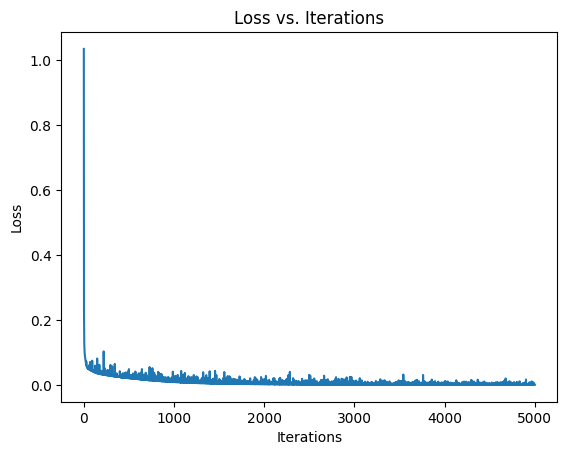

In [25]:
# plot the loss
plt.figure()
plt.plot(hist_2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()

/var/folders/9_/0br367712px91zs6v7644rd40000gn/T/ipykernel_22253/1133576787.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load('mode

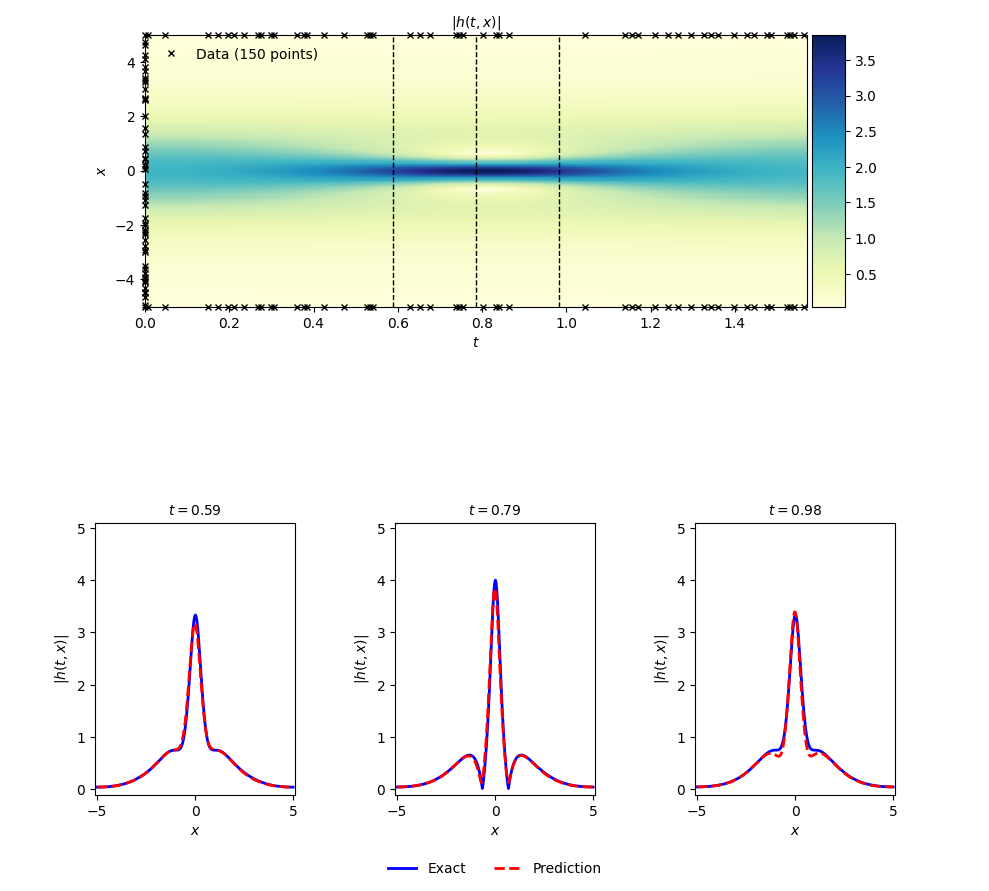

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

X_star = np.hstack((
    np.repeat(x, len(t))[:, None],            # Reshape to (N, 1)
    np.tile(t.flatten(), len(x))[:, None]    # Flatten `t` and reshape to (N, 1)
))
# Assuming your X_star, H_pred, x, t, Exact_h, etc. are already defined properly
# Generate the required plot

# Define domain bounds and load predictions
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
x = np.linspace(lb[0], ub[0], Exact_h.shape[0])  # spatial domain
t = np.linspace(lb[1], ub[1], Exact_h.shape[1])  # temporal domain

# Generate predictions
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
model.model.load_state_dict(torch.load('models/nn_model_49000.pth'))
u_pred, v_pred, _, _ = model.predict(X_star)

# Prediction: make sure you generated the h_pred
h_pred = np.sqrt(u_pred**2 + v_pred**2)
H_pred = griddata(X_star, h_pred.flatten(), (x[:, None], t[None, :]), method='cubic')

# Exact solution: compute h
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
Exact_h = Exact_h  # Match dimensions with H_pred for plotting

# Create training points for visualization (as in your original code)
X0 = np.concatenate((x0, 0 * x0), axis=1)  # (x0, 0)
X_lb = np.concatenate((0 * tb + lb[0], tb), axis=1)  # (lb[0], tb)
X_ub = np.concatenate((0 * tb + ub[0], tb), axis=1)  # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Row 0: h(t,x) plot
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.95, bottom=0.61, left=0.15, right=0.85, wspace=0)
ax_h = plt.subplot(gs0[:, :])

h_plot = ax_h.imshow(
    H_pred,
    interpolation='nearest',
    cmap='YlGnBu',
    extent=[lb[1], ub[1], lb[0], ub[0]],
    origin='lower',
    aspect='auto',
)
divider = make_axes_locatable(ax_h)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_plot, cax=cax)

ax_h.plot(
    X_u_train[:, 1],
    X_u_train[:, 0],
    'kx',
    label=f"Data ({X_u_train.shape[0]} points)",
    markersize=4,
    clip_on=False,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax_h.plot(t[75] * np.ones((2, 1)), line, 'k--', linewidth=1)
ax_h.plot(t[100] * np.ones((2, 1)), line, 'k--', linewidth=1)
ax_h.plot(t[125] * np.ones((2, 1)), line, 'k--', linewidth=1)

ax_h.set_xlabel('$t$')
ax_h.set_ylabel('$x$')
ax_h.legend(frameon=False, loc='best')
ax_h.set_title('$|h(t,x)|$', fontsize=10)

# Row 1: Slices of h(t,x) at specific times
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.34, bottom=0, left=0.1, right=0.9, wspace=0.5)

time_indices = [75, 100, 125]  # Indices for the time points to be plotted
for i, t_idx in enumerate(time_indices):
    ax_slice = plt.subplot(gs1[0, i])
    ax_slice.plot(x, Exact_h[:,t_idx], 'b-', linewidth=2, label='Exact')  # Plot spatial points at time t_idx
    ax_slice.plot(x, H_pred[:,t_idx], 'r--', linewidth=2, label='Prediction')
    ax_slice.set_xlabel('$x$')
    ax_slice.set_ylabel('$|h(t,x)|$')
    ax_slice.set_xlim([-5.1,5.1])
    ax_slice.set_ylim([-0.1,5.1])    
    ax_slice.set_title(f'$t = {t[t_idx]:.2f}$', fontsize=10)
    if i == 1:
        ax_slice.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
torch.save(model.model.state_dict(), 'trained_model_adam.pth')
print("Model saved after Adam training.")

Model saved after Adam training.


In [ ]:
# Initialize the model
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

# Load the saved weights
model.model.load_state_dict(torch.load('trained_model_adam.pth'))
print("Model weights loaded. Ready for L-BFGS fine-tuning.")

Model weights loaded. Ready for L-BFGS fine-tuning.


<ipython-input-32-e56df2da17d3>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load('trained_model_adam.pth'))
